# HW 3
### Unsupervised Learning
#### Gian Zlupko

First, I import the wine data to get started.

In [31]:
import pandas as pd
import os

# change working directory 
os.chdir('/Users/gianzlupko/Desktop/GR5073 ML/gr5073_ML/data')

# read in the red and white wine data sets
red_wine = pd.read_csv("winequality-red.csv", sep = ';') 

# inspect the data 
red_wine.head()


0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

Next, I scale the data as data should be standardzied prior to using cluster analysis and PCA. 

In [56]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler() 
scaler.fit(red_wine)
wine_scaled = pd.DataFrame(scaler.transform(red_wine), columns = red_wine.columns) # retains col names for later use 

# inspect data again to confirm that it was scaled 
print(wine_scaled)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0         -0.528360          0.961877    -1.391472       -0.453218  -0.243707   
1         -0.298547          1.967442    -1.391472        0.043416   0.223875   
2         -0.298547          1.297065    -1.186070       -0.169427   0.096353   
3          1.654856         -1.384443     1.484154       -0.453218  -0.264960   
4         -0.528360          0.961877    -1.391472       -0.453218  -0.243707   
...             ...               ...          ...             ...        ...   
1594      -1.217796          0.403229    -0.980669       -0.382271   0.053845   
1595      -1.390155          0.123905    -0.877968       -0.240375  -0.541259   
1596      -1.160343         -0.099554    -0.723916       -0.169427  -0.243707   
1597      -1.390155          0.654620    -0.775267       -0.382271  -0.264960   
1598      -1.332702         -1.216849     1.021999        0.752894  -0.434990   

      free sulfur dioxide  

#### 1. Use K Means Cluster Analysis to identify cluster(s) of observations that have high and low values of the wine quality. (Assume all variables are continuous.) Describe variables that cluster with higher values of wine quality. Describe variables that cluster with lower values of wine quality.

If you want to make a good bottle of wine, then what characteristics are most important according to this analysis

To determine an appropriate value for `k` clusters using k-means, I use the elbow curve method below. The elbow curve method plots the differences in within-group sum of squares (WGSS) for each cluster and the elbow in the curve is a heuristic used to identify a value of `k` clusters that substantially reduces WGSS. 

Text(0.5, 1.0, 'Elbow curve')

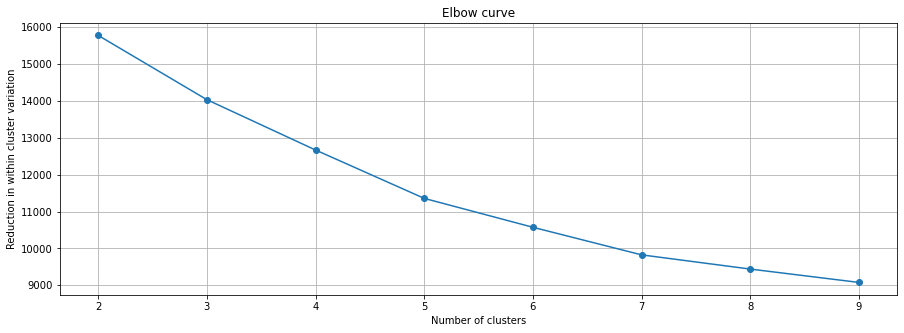

In [57]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore') # disabling warnings for this code chunk 

within_cluster_variance = [] # initiate empty list with no data

# build models for range of ks from 2 to 20
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(wine_scaled)
    within_cluster_variance.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), within_cluster_variance, marker='o')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Reduction in within cluster variation')

plt.title('Elbow curve')  #Choose k at elbow of plot as a general rule.  We want a small enough number of categories to 
                          # such that we can still learn something meaningful from them via exploration of our variables.

While the curve method does not reveal a strong elbow in the plot, it appears that 7 clusters substantially reduces WSS with diminishing retunrs thereafter. Thus, I will use k = 7 clusters for k-means on the red wine data. Next, I fit the k-means model and I also visually inspect a sample plot of the clusters colored by group to examine their dispersion (specifically on the first two features below). 

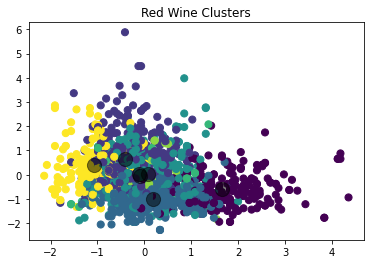

In [66]:
# fit k-means to the data
kmeans1 = KMeans(n_clusters = 7, random_state = 42)
kmeans1.fit(wine_scaled)
y_kmeans = kmeans1.predict(wine_scaled)

#plot data colored by k-means clusters from model
plt.scatter(wine_scaled.iloc[:, 0], wine_scaled.iloc[:, 1], c = y_kmeans, s=50, cmap='viridis')
plt.title("Red Wine Clusters")
centers = kmeans1.cluster_centers_ # extract final centroids from each cluster
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


The scatter plot shows the cloud of data points associated with each of the clusters as well as the centroids of each cluster in 2-dimensional space. The visual is not very useful in examining the differences between these sub-groups of the red wine data for the first two features. However, differences in quality by cluster may be more apparent. To assess which observations have high and low values of the wine quality, I first merge the cluster labels to the original data. 

In [94]:
wine_cluster = pd.DataFrame(wine_scaled)
wine_cluster['Cluster'] = kmeans1.labels_
wine_cluster['Cluster'] = wine_cluster.Cluster.astype('category')

# inspect new column with cluster labels 
wine_cluster.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Cluster
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823,1
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,-0.787823,1
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,-0.787823,1
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,0.450848,0
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823,1


Next, I can visualize the differences in wine quality in a variety of ways. Below, I use a boxplot to examine which wine sub-groups are associated with higher or lower ratings of quality. 

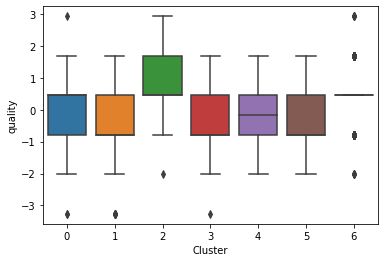

In [87]:
import seaborn as sns 
sns.boxplot(x = wine_cluster['Cluster'], y = wine_cluster['quality'])

The boxplot indicates that Cluster 3 has high values of quality (note: the third cluster is labeled 2, since python starts with 0). For more granularity, to see the other clusters that are associated with high or low wine quality, we can filter the data set by grouping each cluster and calculating each cluster's mean quality score. 

In [116]:

# calculate mean quality scores by cluster
wine_cluster.groupby(['Cluster'])['quality'].mean()


Cluster
0    0.156165
1   -0.521662
2    1.055668
3   -0.425017
4   -0.022761
5   -0.360695
6    0.468544
Name: quality, dtype: float64

We see that Cluster 7 (Python row 6) has the second highest quality score and cluster 2 (row 1) has the lowest quality wine score. Finally, to determine if the quality is significantly different across clusters, we can run a simple ANOVA. 

In [98]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# group by 
qual_data = wine_cluster[['Cluster', 'quality']] 
groups = qual_data.groupby('Cluster')
groups.head()

# Ordinary Least Squares (OLS) model
model = ols('quality ~ C(Cluster)', data= qual_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table) 


                 sum_sq      df           F         PR(>F)
C(Cluster)   534.003516     6.0  133.041691  1.142261e-136
Residual    1064.996484  1592.0         NaN            NaN


The ANOVA results indicate that there are statistically significant mean differences in wine quality across the clusters identified by k-means. 

Next, in addition to identifying clusters with high and low quality scores, this question also asks us to describe variables that cluster with higher and lower values of wine quality. To address this question, we can examine correlations between wine quality scores with the other features in the data set. 

In [141]:
# correlation matrix 
features_only = wine_cluster.drop(columns = ["Cluster"]) 
corr_matrix = features_only.corr() 

corr_matrix.style.background_gradient(cmap = 'coolwarm')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


The results indicate that alcohol, citric acid, and sulphates are positively related to wine quality. Thus, better wines have greater levels of these characteristics according to correlational analysis. In contrast, poor wine quality in associated with density, total sulfur dioxide, and volatile acidity. Specifically, each of these characteristics of wine are inversely related to quality. This means that as the presence of each of these increases in wine, the quality of the wine decreases. Thus, lower quality wines are expected to contain greater levels of density, sulfur dioxide, and volatile acidity. Drawing on both of these findings, the results indicate that in order to make a good bottle of wine, producers should focus on low density and low sulfur wines, for example, while increasing the level of alcohol, citric acid and sulphates.

#### 2. Use Hierarchical Cluster Analysis to identify cluster(s) of observations that have high and low values of the wine quality. (Assume all variables are continuous.) Use complete linkage and the same number of groups that you found to be the most meaningful in question 1.

In [175]:
hca_data = wine_scaled.drop("Cluster", axis = 1)

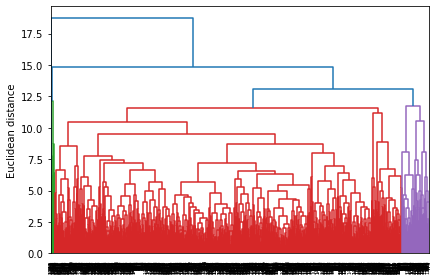

In [177]:
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

row_clusters = linkage(pdist(hca_data, metric='euclidean'), method='complete') 


from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.show()

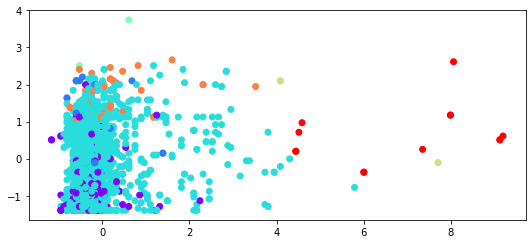

In [183]:
cluster = AgglomerativeClustering(n_clusters = 7, 
affinity = 'euclidean', linkage = 'complete')

cluster.fit_predict(hca_data)


# plot results 
plt.scatter(hca_data["residual sugar"], hca_data["citric acid"], c = cluster.labels_, cmap = 'rainbow')

In [180]:
hca_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,-0.787823
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,-0.787823
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,0.450848
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823
